# Final Project Report
##### *Cynthia Wang, Luke Angelo Santiago, Tim Generalov, Sarah Porcheron*

## Introduction

## Methods

## Results

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

Warning message:
"package 'forcats' was built under R version 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

Warning message:
"package 'infer' was built under R version 4.4.2"
─

### Code

In [2]:
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- read_csv(url) |>

    # experience and gender changed to factor type in order to be treated as category
    mutate(experience = as.factor(experience),
           gender = as.factor(gender)) |>

    # removed hashedEmail, individualId, and organizationName because they have no information
    # removed subscribe and name because they have no useful information about the type of user
    select(experience, played_hours, gender, age)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Graph Code

In [3]:
# number of players in each experience level
num_players_by_exp <- players |>
    group_by(experience) |>
    summarize(count = n()) |>
    arrange(count)

In [4]:
# number of players from a certain gender
num_players_by_gender <- players |>
    group_by(gender) |>
    summarize(count = n()) |>
    arrange(count)

In [5]:
# hours contributed by experience level and gender
experience_vs_hours <- players |>
    ggplot(aes(x = experience, y = played_hours, fill = gender)) +
    geom_histogram(stat = "identity", position = "dodge") +
    labs(x = "Experience",
         y = "# of hours played",
         title = "Hours Contribution by Experience and Gender") +
    theme(text = element_text(size = 15)) +
    scale_fill_brewer(palette = 'Set2')

Warning message in geom_histogram(stat = "identity", position = "dodge"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


In [6]:
# each experience level group's mean hours based on age
players_bar <- players |>
    filter(age < 51) |>
    group_by(age, experience) |>
    summarize(avg_played_hours = mean(played_hours)) |>
    ggplot(aes(x = age, y = avg_played_hours, fill = experience)) +
    geom_bar(stat = "identity") +
    facet_grid(rows = vars(experience)) +
    labs(x = "Age",
         y = "Average hours played",
         fill = "Experience level",
         title = "Mean Playing Hours Compared to Age and Experience") +
    theme(text = element_text(size = 15)) +
    scale_fill_brewer(palette = 'Paired')

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


In [7]:
# distribution of played hours
played_hours <- ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "steelblue", color = "black") +
  labs(title = "Distribution of Total Played Hours",
       x = "Total Played Hours",
       y = "Number of Players") +
  theme(text = element_text(size = 15))


In [8]:
# graph comparing the gender make-up in each experience level group
gender_makeup <- players |>
    group_by(gender, experience) |>
    summarize(count = n()) |>
    ggplot(aes(x = count, y = experience, fill = gender)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Gender make-up (%)",
         y = "Experience",
         title = "Gender Make-up of Experience Level Groups") +
    theme(text = element_text(size = 15)) +
    scale_fill_brewer(palette = 'Set2')

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.


#### Classification Model Code

In [37]:
# splitting the data 
players_split <- initial_split(players, prop = 0.7, strata = played_hours)
players_train <- training(players_split) # 136 observations
players_test <- testing(players_split) # 60 observations

experience,played_hours,gender,age
<fct>,<dbl>,<fct>,<dbl>
Veteran,0.0,Male,17
Regular,0.1,Male,21
Amateur,0.0,Female,17
⋮,⋮,⋮,⋮
Amateur,32.0,Male,22
Pro,1.7,Male,17
Amateur,2.3,Male,17


In [39]:
# training the data
players_recipe <- recipe(played_hours ~ ., data = players)

players_spec <- nearest_neighbor(weight_func = "rectangular",
                                 neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 18, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1)) 

players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

kmin <- players_results |>
    filter(mean == min(mean)) |>
    pull(neighbors)

In [41]:
# testing the data
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_summary <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == 'rmse')

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,19.81184,18,7.392031,Preprocessor1_Model001
2,rmse,standard,26.32570,18,6.866507,Preprocessor1_Model002
3,rmse,standard,21.37810,18,6.681096,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
98,rmse,standard,20.00585,18,6.078076,Preprocessor1_Model098
99,rmse,standard,20.03414,18,6.079826,Preprocessor1_Model099
100,rmse,standard,20.03265,18,6.078571,Preprocessor1_Model100


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
53,rmse,standard,19.0928,18,6.197215,Preprocessor1_Model053


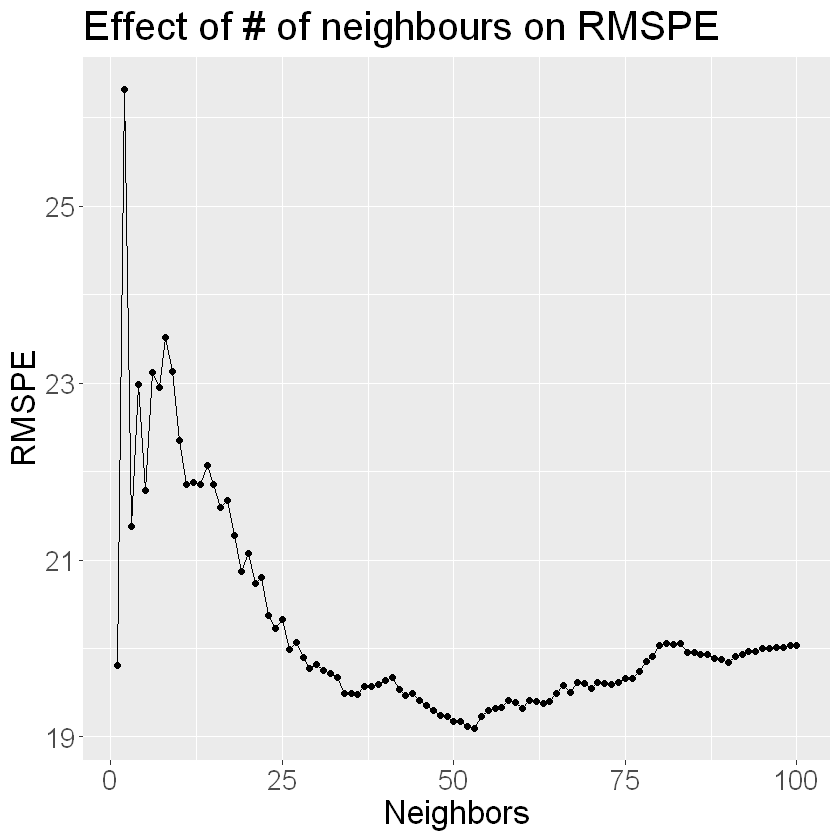

In [40]:
# displays results of training to find the best k value
players_results

players_results |>
filter(mean == min(mean))

ggplot(players_results, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors",
     y = "RMSPE",
     title = "Effect of # of neighbours on RMSPE") +

theme(text = element_text(size = 20))

In [42]:
# displays the RMSPE of the data at the best k value (k = ...)
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,20.28861


### Graphs

In [ ]:
players
num_players_by_exp
num_players_by_gender

options(repr.plot.width = 15, repr.plot.height = 6)

plot_grid(experience_vs_hours, players_bar,
          ncol = 2)

options(repr.plot.width = 15, repr.plot.height = 6)

plot_grid(played_hours, gender_makeup,
          ncol = 2)

Insights seen from the plots:
- Male players vastly dominate the participant demographic. Consequently, they deliver the most hours to the study despite having the lowest hours contributed per capita.
- Regular and amateur players contributed the most hours to the study.
- Non-binary and female players tend to play more.
- The dataset is mostly comprised of pre-adolescents and young adults.

## Discussion

## References (?)